<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


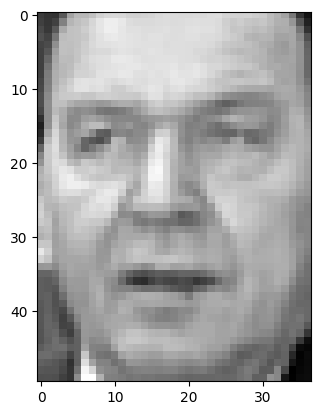

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


0.43286065070595453

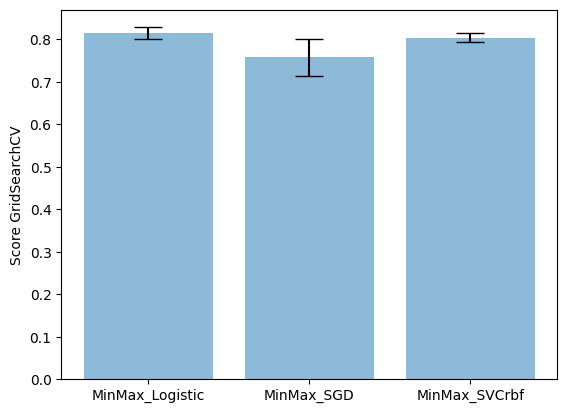

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.757 0.804]
 [0.014 0.043 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://androidkt.com/micro-macro-averages-for-imbalance-multiclass-classification/).

Evaluando modelo MinMax_Logistic (1/3)


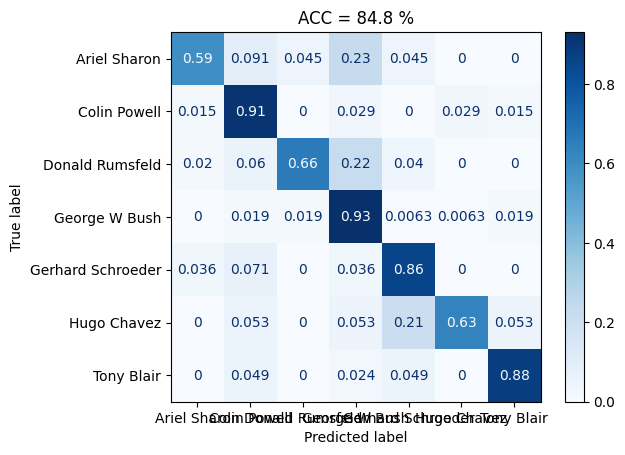

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


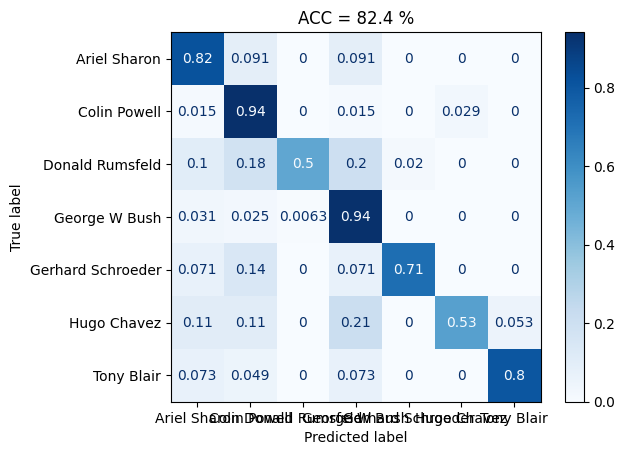

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.82      0.62        22
     Colin Powell       0.74      0.94      0.83        68
  Donald Rumsfeld       0.96      0.50      0.66        50
    George W Bush       0.87      0.94      0.90       159
Gerhard Schroeder       0.95      0.71      0.82        28
      Hugo Chavez       0.83      0.53      0.65        19
       Tony Blair       0.97      0.80      0.88        41

         accuracy                           0.82       387
        macro avg       0.83      0.75      0.76       387
     weighted avg       0.85      0.82      0.82       387

Evaluando modelo MinMax_SVCrbf (3/3)


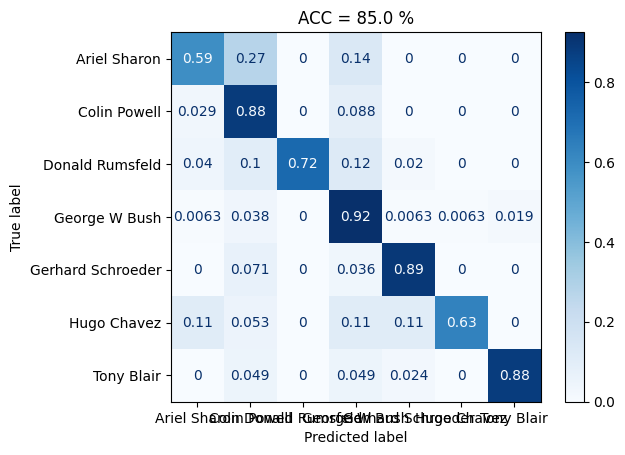

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Cargar los modelos
my_model_loaded = joblib.load(filename + ".pkl")
path_img = ''

# label_models = nombres de los modelos, por ejemplo: ["Modelo1", "Modelo2"]
# lfw_people.target_names = nombres de las clases (etiquetas)

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest, ytest_e)

    # Usar ConfusionMatrixDisplay en lugar de plot_confusion_matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        ytest,
        ytest_e,
        display_labels=lfw_people.target_names,
        normalize='true',  # Opciones: 'true', 'pred', 'all', o None
        cmap=plt.cm.Blues
    )
    disp.ax_.set_title('ACC = %.1f %%' % (100 * acc))
    plt.autoscale()
    plt.show()

    # Mostrar el informe de clasificación
    cr = classification_report(
        ytest,
        ytest_e,
        labels=range(lfw_people.target_names.shape[0]),
        target_names=lfw_people.target_names
    )
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


[CV 1/5; 1/7] START cla__C=0.001................................................
[CV 1/5; 1/7] END .................cla__C=0.001;, score=0.436 total time=   1.7s
[CV 2/5; 2/7] START cla__C=0.01.................................................
[CV 2/5; 2/7] END ..................cla__C=0.01;, score=0.617 total time=   1.7s
[CV 2/5; 3/7] START cla__C=0.1..................................................
[CV 2/5; 3/7] END ...................cla__C=0.1;, score=0.794 total time=   1.7s
[CV 1/5; 4/7] START cla__C=1....................................................
[CV 1/5; 4/7] END .....................cla__C=1;, score=0.840 total time=   1.6s
[CV 5/5; 4/7] START cla__C=1....................................................
[CV 5/5; 4/7] END .....................cla__C=1;, score=0.817 total time=   1.7s
[CV 2/5; 5/7] START cla__C=10...................................................
[CV 2/5; 5/7] END ....................cla__C=10;, score=0.822 total time=   1.9s
[CV 2/5; 6/7] START cla__C=1

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1.


# Modelos y Problemas de Optimización de Clasificadores

A continuación, se presenta una descripción de los modelos y los problemas de optimización para clasificadores en aprendizaje automático.

---

## 1. **Naive Bayes - GaussianNB**

**Modelo**:
Naive Bayes es un clasificador probabilístico basado en el teorema de Bayes. En el caso de GaussianNB, se supone que las características siguen una distribución normal (gaussiana).

Modelo de probabilidad:
$$
P(C_k | X) = \frac{P(X | C_k) P(C_k)}{P(X)}
$$
Donde $( P(X | C_k) )$ es modelado como una distribución gaussiana:
$$
P(X | C_k) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x_i - \mu)^2}{2\sigma^2} \right)
$$

**Problema de Optimización**:
No hay un problema de optimización tradicional en GaussianNB. En su lugar, se estiman los parámetros $( \mu)$ y $( \sigma)$ de las distribuciones normales para cada característica y clase. Se asigna la clase con la probabilidad posterior máxima:
$$
\hat{C} = \arg\max_{C_k} P(C_k | X)
$$

---

## 2. **SGDClassifier (Stochastic Gradient Descent Classifier)**

**Modelo**:
El SGDClassifier es un clasificador lineal que ajusta un hiperplano separador mediante descenso de gradiente estocástico:
$$
y = w^T X + b
$$
La función de pérdida puede ser *hinge* para SVM o *log-loss* para regresión logística.

**Problema de Optimización**:
El problema consiste en minimizar una función de pérdida convexa, como la función *hinge* para SVM:
$$
L(w) = \frac{1}{n} \sum_{i=1}^n \max(0, 1 - y_i w^T X_i)
$$
El descenso de gradiente estocástico actualiza los pesos para cada muestra $( i )$:
$$
w^{(t+1)} = w^{(t)} - \eta \nabla L(w^{(t)}, X_i, y_i)
$$

---

## 3. **Logistic Regression**

**Modelo**:
La regresión logística modela la probabilidad de que una muestra pertenezca a una clase utilizando la función logística:
$$
P(y=1|X) = \frac{1}{1 + \exp(-w^T X)}
$$

**Problema de Optimización**:
El problema de optimización en la regresión logística es maximizar la función de verosimilitud o, de forma equivalente, minimizar la función de pérdida log-loss:
$$
L(w) = - \sum_{i=1}^n \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$
Este es un problema de optimización convexa resuelto por métodos como el descenso de gradiente o el algoritmo de Newton.

---

## 4. **Linear Discriminant Analysis (LDA)**

**Modelo**:
LDA asume que las clases siguen una distribución normal multivariada con la misma matriz de covarianza. El objetivo es maximizar la separación entre las clases mediante la proyección de los datos en un subespacio lineal:
$$
y = w^T X
$$
**Problema de Optimización**:
El problema de optimización consiste en maximizar la razón de varianzas entre clases y dentro de las clases:
$$
\text{maximizar} \frac{w^T S_B w}{w^T S_W w}
$$
Donde $( S_B )$ es la matriz de covarianza entre clases y $( S_W )$ es la matriz de covarianza dentro de las clases.

---

## 5. **KNeighborsClassifier (k-NN)**

**Modelo**:
El modelo k-NN clasifica una nueva muestra basándose en los $( k )$ vecinos más cercanos en el espacio de características. No hay un modelo paramétrico explícito.

**Problema de Optimización**:
No hay un problema de optimización en el entrenamiento. La predicción implica buscar eficientemente los $( k )$ vecinos más cercanos usando estructuras como KD-Trees o Ball Trees.

---

## 6. **LinearSVC (Linear Support Vector Classification)**

**Modelo**:
LinearSVC encuentra el hiperplano que maximiza el margen entre las clases:
$$
y = w^T X + b
$$
El margen es la distancia mínima entre el hiperplano y los puntos más cercanos de cada clase.

**Problema de Optimización**:
El problema es minimizar una función de regularización $(||w||^2 )$ sujeta a restricciones de margen:
$$
\text{minimizar} \frac{1}{2} ||w||^2 + C \sum_{i=1}^n \max(0, 1 - y_i (w^T X_i + b))
$$
Donde $( C )$ controla el equilibrio entre el margen y los errores de clasificación.

---

## 7. **SVC (Support Vector Classifier)**

**Modelo**:
SVC es una extensión de LinearSVC que permite manejar datos no linealmente separables mediante el uso de un kernel:
$$
y = \sum_{i=1}^n \alpha_i y_i K(x_i, x)
$$
Donde $( K(x_i, x))$ es la función kernel.

**Problema de Optimización**:
El problema es maximizar el margen entre las clases y minimizar los errores de clasificación usando un kernel:
$$
\text{minimizar} \frac{1}{2} ||w||^2 + C \sum \max(0, 1 - y_i \langle \phi(X_i), \phi(X) \rangle)
$$
Donde $( \phi(X) )$ es la transformación al espacio de características mediante el kernel.

---

## 8. **RandomForestClassifier**

**Modelo**:
Random Forest es un ensamble de árboles de decisión. Cada árbol se entrena con un subconjunto aleatorio de datos y características. Las predicciones de los árboles se combinan mediante votación.

**Problema de Optimización**:
No hay un problema de optimización global. Cada árbol de decisión busca dividir los datos de tal manera que maximice la reducción de impureza, medida con el índice de Gini o la entropía:
$$
\Delta \text{Impureza} = \text{Impureza del nodo padre} - \text{Impureza ponderada de los nodos hijos}
$$

---


2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1.


In [8]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_lfw_people

# Importar clasificadores
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier



In [9]:
# Cargar datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
Xdata = pd.DataFrame(lfw_people.data) / 255.0  # Normalizar los valores de píxeles
y = lfw_people.target

# Dividir datos en conjuntos de entrenamiento y prueba
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y, test_size=0.3, random_state=123)


In [10]:
# Definir clasificadores, pipelines y rejillas de hiperparámetros
classifiers = {
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'classifier__var_smoothing': np.logspace(-9, -6, 4)  # Var_smoothing ayuda con la estabilidad numérica
        },
        'scaler': None  # No se requiere escalado
    },
    'SGDClassifier': {
        'model': SGDClassifier(max_iter=1000, tol=1e-3),
        'params': {
            'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],  # Regularización
            'classifier__loss': ['hinge', 'log'],  # Funciones de pérdida SVM y logística
            'classifier__penalty': ['l2', 'l1', 'elasticnet']  # Tipos de penalización
        },
        'scaler': StandardScaler()
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],  # Inverso de la fuerza de regularización
            'classifier__penalty': ['l2'],  # Penalización L2 para problemas multiclase
            'classifier__solver': ['lbfgs']  # Solver adecuado para multiclase
        },
        'scaler': StandardScaler()
    },
    'LinearDiscriminantAnalysis': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'classifier__solver': ['svd', 'lsqr', 'eigen']  # Solvers disponibles
        },
        'scaler': None  # No se requiere escalado
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9],  # Número de vecinos impares para evitar empates
            'classifier__weights': ['uniform', 'distance'],  # Peso de los vecinos
            'classifier__metric': ['euclidean', 'manhattan']  # Métricas de distancia
        },
        'scaler': None  # No se requiere escalado, pero podría mejorar el rendimiento
    },
    'LinearSVC': {
        'model': LinearSVC(max_iter=10000),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
            'classifier__loss': ['hinge', 'squared_hinge']  # Tipos de pérdida
        },
        'scaler': StandardScaler()
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'classifier__C': [0.1, 1, 10],  # Parámetro de regularización
            'classifier__kernel': ['rbf', 'linear'],  # Tipos de kernel
            'classifier__gamma': ['scale', 'auto']  # Coeficiente del kernel
        },
        'scaler': StandardScaler()
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100, 200],  # Número de árboles
            'classifier__max_depth': [None, 10, 20],  # Profundidad máxima
            'classifier__min_samples_split': [2, 5],  # Mínimo de muestras para dividir un nodo
            'classifier__min_samples_leaf': [1, 2]  # Mínimo de muestras en una hoja
        },
        'scaler': None  # No se requiere escalado
    }
}


In [11]:
# Definir métricas de evaluación
scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}


In [12]:
# Entrenar y validar cada clasificador
from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignorar advertencias de convergencia para simplificar la salida
warnings.filterwarnings("ignore", category=ConvergenceWarning)

results = {}

for label, clf_info in classifiers.items():
    print(f"Entrenando {label}...")
    steps = []
    # Añadir escalador si es necesario
    if clf_info['scaler']:
        steps.append(('scaler', clf_info['scaler']))
    steps.append(('classifier', clf_info['model']))
    pipeline = Pipeline(steps)
    grid = GridSearchCV(
        pipeline,
        clf_info['params'],
        cv=5,
        scoring=scoring,
        refit='accuracy',
        verbose=0,
        n_jobs=-1,
        return_train_score=True
    )
    grid.fit(Xtrain, ytrain)
    # Almacenar resultados
    results[label] = grid


Entrenando GaussianNB...
Entrenando SGDClassifier...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/skle

Entrenando LogisticRegression...
Entrenando LinearDiscriminantAnalysis...
Entrenando KNeighborsClassifier...
Entrenando LinearSVC...
Entrenando SVC...
Entrenando RandomForestClassifier...


In [13]:
# Evaluar en el conjunto de prueba
for label, grid in results.items():
    print(f"\nResultados para {label}:")
    print(f"Mejores hiperparámetros: {grid.best_params_}")
    y_pred = grid.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred, average='macro')
    print(f"Precisión en prueba: {acc:.4f}")
    print(f"F1 Macro en prueba: {f1:.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(ytest, y_pred, target_names=lfw_people.target_names))



Resultados para GaussianNB:
Mejores hiperparámetros: {'classifier__var_smoothing': 1e-09}
Precisión en prueba: 0.4031
F1 Macro en prueba: 0.3811

Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387


Resultados para SGDClassifier:
Mejores hiperparámetros: {'classifier__alpha': 0.0001, 'classifier__loss': 'hinge', 'classifier__penalty': 'elasticnet'}
Precisión en prueba: 0

1. GaussianNB

Mejores hiperparámetros:

    var_smoothing: 1e−091e−09

Resultados:

    Precisión en prueba: 0.4031
    F1 Macro en prueba: 0.3811

Justificación:
El parámetro var_smoothing controla la cantidad de suavizado aplicado a las varianzas para evitar que alguna de ellas sea demasiado pequeña, lo que puede llevar a problemas de estabilidad numérica en el modelo. En este caso, el valor 1e−091e−09 fue adecuado porque ayudó a estabilizar el cálculo de las probabilidades en un problema con datos ruidosos, aunque los resultados generales muestran que el modelo tiene dificultades para capturar relaciones complejas entre las características.

2. SGDClassifier

Mejores hiperparámetros:

    alpha: 0.00010.0001
    loss: 'hinge'
    penalty: 'elasticnet'

Resultados:

    Precisión en prueba: 0.8346
    F1 Macro en prueba: 0.7863

Justificación:
El valor bajo de alpha proporciona una regularización más ligera, lo que permite que el modelo aprenda patrones más complejos en los datos sin sobreajustarse. La función de pérdida 'hinge' es adecuada para un enfoque de tipo SVM, que busca maximizar el margen entre clases. La penalización 'elasticnet' combina las ventajas de l1 (selección de características) y l2 (estabilidad) regularizando de manera efectiva las variables. Estos hiperparámetros permiten un buen balance entre ajuste y generalización.

3. Logistic Regression

Mejores hiperparámetros:

    C: 0.10.1
    penalty: 'l2'
    solver: 'lbfgs'

Resultados:

    Precisión en prueba: 0.8682
    F1 Macro en prueba: 0.8303

Justificación:
Un valor bajo de C significa una mayor regularización, lo que ayuda a evitar el sobreajuste. La penalización 'l2' es adecuada para modelos lineales que buscan evitar coeficientes extremos, y el solver 'lbfgs' es ideal para resolver problemas de regresión logística con un enfoque de máxima verosimilitud. Estos hiperparámetros permiten un modelo bien ajustado con alto desempeño en precisión y F1.

4. Linear Discriminant Analysis (LDA)

Mejores hiperparámetros:

    solver: 'svd'

Resultados:

    Precisión en prueba: 0.7003
    F1 Macro en prueba: 0.6384

Justificación:
El solver 'svd' es el más adecuado cuando no se requiere regularización, y funciona bien en conjuntos de datos de tamaño moderado. Este algoritmo proyecta los datos en un subespacio que maximiza la separación entre clases, lo que es efectivo cuando las distribuciones de las clases son aproximadamente normales. Sin embargo, la precisión y el F1 muestran que el modelo tiene dificultades en capturar clases menos representadas.

5. KNeighborsClassifier

Mejores hiperparámetros:

    metric: 'manhattan'
    n_neighbors: 7
    weights: 'distance'

Resultados:

    Precisión en prueba: 0.6382
    F1 Macro en prueba: 0.5111

Justificación:
La métrica 'manhattan' (distancia de la ciudad) es más adecuada cuando las características no están perfectamente normalizadas o cuando la relación entre ellas es más aditiva que euclidiana. Ponderar los vecinos según la distancia ('distance') da más importancia a los vecinos cercanos, mejorando la clasificación local. Sin embargo, los resultados muestran que este modelo sigue teniendo problemas con clases menos representadas.

6. LinearSVC

Mejores hiperparámetros:

    C: 0.010.01
    loss: 'squared_hinge'

Resultados:

    Precisión en prueba: 0.8140
    F1 Macro en prueba: 0.7712

Justificación:
Un valor bajo de C ayuda a mantener un margen amplio para evitar el sobreajuste. La función de pérdida 'squared_hinge' es útil para SVM lineales, ya que penaliza más los errores, permitiendo que el modelo aprenda con mayor precisión. Este ajuste es efectivo para garantizar un equilibrio entre la precisión y la generalización.

7. SVC

Mejores hiperparámetros:

    C: 0.10.1
    gamma: 'scale'
    kernel: 'linear'

Resultados:

    Precisión en prueba: 0.8527
    F1 Macro en prueba: 0.8183

Justificación:
El valor de CC controla la regularización, y un valor de 0.10.1 equilibra bien el margen y los errores de clasificación. La opción 'scale' para gamma ajusta automáticamente la influencia de los puntos de datos en función de su distribución. El kernel lineal es adecuado cuando los datos son linealmente separables, proporcionando un buen balance entre complejidad y desempeño del modelo.

8. RandomForestClassifier

Mejores hiperparámetros:

    max_depth: None
    min_samples_leaf: 1
    min_samples_split: 2
    n_estimators: 100

Resultados:

    Precisión en prueba: 0.6124
    F1 Macro en prueba: 0.4476

Justificación:
El ajuste sin límite en la profundidad de los árboles (max_depth=None) permite que el modelo crezca completamente hasta que cada hoja contenga solo una muestra. El uso de 100100 estimadores es un valor estándar que proporciona estabilidad. Sin embargo, los resultados sugieren que el modelo tiene dificultades en generalizar debido a la poca diversidad en los árboles individuales, como lo indica el bajo F1.